<style>
/* Style pour améliorer la lisibilité et la présentation */
h1 { color: #2E86C1; text-align: center; font-size: 28px; }
h2 { color: #2874A6; font-size: 24px; }
h3 { color: #1B4F72; font-size: 20px; }
h4 { color: #154360; font-size: 18px; }
p, li { font-size: 16px; }
strong { color: #D35400; }
</style>



# Introduction à l’analyse des données géospatiales appliquée au contexte agricole
# Etude spatio-temporelle de l'indice NDVI et SPI au region Beni-mellal khenifra

---
************************************************************************************************************************************************************
#### Réalisé par : **Adam Daoudi** | Eleve ingenieur en Data Science à l'INSEA 
# Année académique : 2024-2025

---

************************************************************************************************************************************************************
## Introduction
ce projet vise à:
+ **analyser et combiner les indices SPI (précipitations) et NDVI (santé de la végétation) avec des méthodes de machine learning pour détecter, caractériser et prédire les épisodes de sécheresse dans le région de Béni-mellal Khenifra.**
+ **Ce travail s’inscrit dans le cadre de la surveillance de la sécheresse agricole, en combinant l’analyse des déficits pluviométriques (SPI) et la réponse de la végétation (NDVI) à l’échelle mensuelle**

---

## *Problematique* :  **Comment combiner les indices SPI (précipitations) et NDVI (santé de la végétation) avec des méthodes de machine learning pour détecter, caractériser et prédire les épisodes de sécheresse dans le region de Béni-mellal Khénifra ?**

## Méthodologie

### A. Collecte et prétraitement des données géospatiales (ex :MODIS, CHIRPS)
- Téléchargement des données satellites MODIS et précipitations CHIRPS.
- Extraction des variables pertinentes.
- Nettoyage, reprojection et découpage des rasters (zones d’étude proposée :Béni Mellal-Khénifra).


### B. Analyse exploratoire et visualisation cartographique
- Visualisation des cartes NDVI et SPI.
- Etude temporelle (évolution mensuelle/annuelle).
- Corrélations entre indices.


### C. Modélisation statistique ou machine learning
- Développement de modèles de d'etection ou de prédiction de sécheresse.
- Application de modèles statistiques ou machine learning.
- Analyse des résultats et validation.



## A. Preparation des Données NDVI et SPI


### Importation des bibliotheque necessaires 

In [105]:
import os
import urllib.request
import time
from datetime import datetime, timedelta
import gzip
import shutil
import geopandas as gpd 
from osgeo import gdal
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio import open as rio_open
from pymodis import downmodis
import glob
import re
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
from scipy.stats import norm, pearsonr
import seaborn as sns 
import matplotlib.pyplot as plt 
import earthaccess 
from pathlib import Path
import logging
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

### Chirps dataset (SPI index)

In [106]:

if False:

    base_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/africa_monthly/tifs/"
    output_dir = "chirps_data"
    os.makedirs(output_dir, exist_ok=True)


    dates = pd.date_range(start="1981-01", end="2025-05", freq="MS")
    formatted_dates = [date.strftime("%Y.%m") for date in dates]

    for date in formatted_dates:
        filename = f'chirps-v2.0.{date}.tif.gz'
        url = base_url + filename
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            print(f"{filename} déjà présent, on passe.")
            continue

        print(f"Téléchargement de {filename}...")


        max_retries = 3
        for attempt in range(max_retries):
            try:
                urllib.request.urlretrieve(url, filepath)
                print(f"Téléchargé : {filename}")
                break
            except Exception as e:
                print(f"Tentative {attempt + 1} échouée : {e}")
                if attempt < max_retries - 1:
                    print("Nouvelle tentative dans 2 secondes...")
                    time.sleep(2)
                else:
                    print(f"Échec du téléchargement de {filename} après {max_retries} tentatives.")


#### decompression

In [107]:
if False:
    input_dir = "chirps_data"
    output_dir = "chirps_tif's"
    os.makedirs(output_dir, exist_ok=True)


    for filename in os.listdir(input_dir):
        if filename.endswith(".tif.gz"):
            gz_path = os.path.join(input_dir, filename)
            tif_filename = filename[:-3]  
            tif_path = os.path.join(output_dir, tif_filename)

            
            if os.path.exists(tif_path):
                print(f"{tif_filename} déjà extrait.")
                continue

            #Décompression
            try:
                with gzip.open(gz_path, 'rb') as f_in, open(tif_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                print(f"Décompressé : {tif_filename}")
            except Exception as e:
                print(f"Erreur avec {filename} : {e}")


#### decoupage

In [108]:
if False:
    input_folder = "chirps_tif's"  # Dossier contenant les fichiers .tif
    output_folder = "chirps_beni_mellal"
    os.makedirs(output_folder, exist_ok=True)

    # Charger le fichier geojson ou shapefile de Beni Mellal-Khénifra
    gdf = gpd.read_file("beni_mellal_khenifra.geojson")  

    # Parcourir les fichiers .tif et les découper
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with rasterio.open(input_path) as src:
                out_image, out_transform = mask(src, gdf.geometry, crop=True)
                out_meta = src.meta.copy()

                # Mettre à jour les métadonnées
                out_meta.update({
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Enregistrer le fichier découpé
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

            print(f"Découpé : {filename}")


In [109]:
def calculer_spi(chirps_data, scale=3):
    rolling_precip= chirps_data.rolling(window= scale , min_periods=1).sum()
    mean_precip = rolling_precip.mean()
    std_precip= rolling_precip.std()

    spi=(rolling_precip  - mean_precip) / std_precip
    return spi

In [110]:
def extract_mean_values(input_folder, index_type, shapefile_path):
    """Extrait les valeurs moyennes des rasters pour la région"""
    gdf = gpd.read_file(shapefile_path)
    results = []
    
    files = sorted([f for f in os.listdir(input_folder) 
                   if f.endswith((".tif", ".tiff"))])
    
    for file in files:
        file_path = os.path.join(input_folder, file)
        
        try:
            with rasterio.open(file_path) as src:
                if gdf.crs != src.crs:
                    gdf = gdf.to_crs(src.crs)
                
                out_image, _ = mask(src, gdf.geometry, crop=True)
                data = out_image[0]
                
                # Nettoyage des données
                data = np.where((data == src.nodata) | np.isnan(data), np.nan, data)
                
                if index_type.upper() == "NDVI":
                    data = data.astype(float) * 0.0001
                    data = np.where((data < -0.2) | (data > 1.0), np.nan, data)
                elif index_type.upper() == "SPI":
                    data = data.astype(float)
                
                mean_value = np.nanmean(data)
                
                # Extraction de la date
                if index_type.upper() == "NDVI":
                    match = re.search(r'(\d{4}\.\d{2}\.\d{2})', file)
                    if match:
                        date_str = match.group(1)
                        date_obj = pd.to_datetime(date_str, format="%Y.%m.%d")
                else:  # SPI/CHIRPS
                    match = re.search(r'(\d{4}\.\d{2})', file)
                    if match:
                        date_str = match.group(1)
                        date_obj = pd.to_datetime(date_str, format="%Y.%m")
                
                if match:
                    results.append({
                        "date": date_obj, 
                        f"mean_{index_type.lower()}": mean_value
                    })
                    
        except Exception as e:
            print(f"Erreur avec {file}: {e}")
    
    df = pd.DataFrame(results)
    df = df.sort_values("date").reset_index(drop=True)
    return df

In [111]:
shapefile_path = "beni_mellal_khenifra.geojson"

In [112]:
spi_df = extract_mean_values("chirps_beni_mellal", "SPI", shapefile_path="beni_mellal_khenifra.geojson")
ndvi_df = extract_mean_values("ndvi_beni_mellal", "NDVI", shapefile_path="beni_mellal_khenifra.geojson")

In [113]:
#calcule de spi reel

spi_df['mean_spi'] = calculer_spi(spi_df['mean_spi'])
spi_df.to_csv('mean_spi_bmk.csv', index=False)
print(f'SPI extrait :{len(spi_df)} observations')

SPI extrait :533 observations


In [114]:
ndvi_df.to_csv("mean_ndvi_bmk.csv", index=False)
print(f"NDVI extrait: {len(ndvi_df)} observations")

NDVI extrait: 1107 observations


In [115]:
#chargement des donnees existantes

ndvi_df = pd.read_csv('mean_ndvi_bmk.csv', parse_dates=['date'])
spi_df = pd.read_csv('mean_spi_bmk.csv', parse_dates=['date'])

In [116]:
# Conversion NDVI mensuel
ndvi_df['month'] = ndvi_df['date'].dt.to_period('M')
monthly_ndvi = ndvi_df.groupby('month')['mean_ndvi'].mean().reset_index()
monthly_ndvi['date'] = monthly_ndvi['month'].dt.to_timestamp()
monthly_ndvi.drop('month', axis=1, inplace=True)

In [117]:
merged_df = pd.merge(spi_df, monthly_ndvi, on='date', how='inner')
merged_df = merged_df.dropna()
print(merged_df)

print(f"\nDonnées fusionnées: {len(merged_df)} observations")
print(f"Période: {merged_df['date'].min()} à {merged_df['date'].max()}")

          date  mean_spi  mean_ndvi
0   2000-02-01  0.150916   0.337062
1   2000-03-01 -0.242526   0.305065
2   2000-04-01 -0.200493   0.295602
3   2000-05-01  0.099761   0.273207
4   2000-06-01 -0.249848   0.229698
..         ...       ...        ...
299 2025-01-01 -0.082909   0.151669
300 2025-02-01 -0.027971   0.159349
301 2025-03-01  0.195337   0.192912
302 2025-04-01  0.553587   0.210821
303 2025-05-01  0.381375   0.179215

[304 rows x 3 columns]

Données fusionnées: 304 observations
Période: 2000-02-01 00:00:00 à 2025-05-01 00:00:00


### EDA

In [118]:
def create_time_series_plot(df, columns, title , save_path=None):
    
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, 6*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    for i, col in enumerate(columns):
        axes[i].plot(df['date'], df[col], color=colors[i], linewidth=2, label=col)
        axes[i].set_title(f'{title} - {col.upper()}', fontsize=14)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(col.upper())
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [119]:

def analyze_seasonality(df, value_col):
    """Analyse les patterns saisonniers"""
    df_copy = df.copy()
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['season'] = df_copy['month'].map({
        12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
        3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
        6: 'Été', 7: 'Été', 8: 'Été',
        9: 'Automne', 10: 'Automne', 11: 'Automne'
    })
    
    # Analyse mensuelle
    monthly_stats = df_copy.groupby('month')[value_col].agg(['mean', 'std', 'min', 'max'])
    
    # Analyse saisonnière
    seasonal_stats = df_copy.groupby('season')[value_col].agg(['mean', 'std', 'min', 'max'])
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Boxplot mensuel
    df_copy.boxplot(column=value_col, by='month', ax=axes[0,0])
    axes[0,0].set_title(f'Distribution mensuelle de {value_col.upper()}')
    axes[0,0].set_xlabel('Mois')
    
    # Boxplot saisonnier
    df_copy.boxplot(column=value_col, by='season', ax=axes[0,1])
    axes[0,1].set_title(f'Distribution saisonnière de {value_col.upper()}')
    
    # Moyennes mensuelles
    monthly_stats['mean'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title(f'Moyennes mensuelles de {value_col.upper()}')
    axes[1,0].set_xlabel('Mois')
    
    # Moyennes saisonnières
    seasonal_stats['mean'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title(f'Moyennes saisonnières de {value_col.upper()}')
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    return monthly_stats, seasonal_stats

In [120]:
def Correlation_analysis(df):
    correlation= df[['mean_spi', 'mean_ndvi']].corr()
    # test de significativite 

    corr_coef, p_value = pearsonr(df['mean_ndvi'].dropna(), df['mean_spi'].dropna())
    # vis 
    fig , axes = plt.subplots(1, 2, figsize=(15, 6))

    # mat  de cprrelation 
    sns.heatmap(correlation, annot=True, cmap='RdBu_r',center=0, ax= axes[0])
    axes[0].set_title('Matrrice de correlation NDVI-SPI')
     # Scatter plot
    axes[1].scatter(df['mean_spi'], df['mean_ndvi'], alpha=0.6, color='green')
    axes[1].set_xlabel('SPI')
    axes[1].set_ylabel('NDVI')
    axes[1].set_title(f'Relation NDVI-SPI (r={corr_coef:.3f}, p={p_value:.3f})')
    
    # Ligne de régression
    z = np.polyfit(df['mean_spi'].dropna(), df['mean_ndvi'].dropna(), 1)
    p = np.poly1d(z)
    axes[1].plot(df['mean_spi'], p(df['mean_spi']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    return corr_coef, p_value


In [121]:
output_dir= "C:\\Users\\CE PC\\Desktop\\Drought monitoring\\ndvi_data"
url = 'http://www.cgms-maroc.ma/ndvi/'

In [122]:
date_debut=datetime(2000, 1, 1)
date_actuelle= datetime.now()

In [123]:
os.makedirs(output_dir, exist_ok=True)

In [124]:
import requests

reqs = requests.get(url)
soup= BeautifulSoup(reqs.text, 'html.parser')

In [125]:
folders = [link['href'] for link in soup.find_all('a') if link['href'].endswith("/")]
folders

['/',
 '2000.02.18/',
 '2000.03.05/',
 '2000.03.21/',
 '2000.04.06/',
 '2000.04.22/',
 '2000.05.08/',
 '2000.05.24/',
 '2000.06.09/',
 '2000.06.25/',
 '2000.07.11/',
 '2000.07.27/',
 '2000.08.12/',
 '2000.08.28/',
 '2000.09.13/',
 '2000.09.29/',
 '2000.10.15/',
 '2000.10.31/',
 '2000.11.16/',
 '2000.12.02/',
 '2000.12.18/',
 '2001.01.01/',
 '2001.01.17/',
 '2001.02.02/',
 '2001.02.18/',
 '2001.03.06/',
 '2001.03.22/',
 '2001.04.07/',
 '2001.04.23/',
 '2001.05.09/',
 '2001.05.25/',
 '2001.06.10/',
 '2001.06.26/',
 '2001.07.12/',
 '2001.07.28/',
 '2001.08.13/',
 '2001.08.29/',
 '2001.09.14/',
 '2001.09.30/',
 '2001.10.16/',
 '2001.11.01/',
 '2001.11.17/',
 '2001.12.03/',
 '2001.12.19/',
 '2002.01.01/',
 '2002.01.17/',
 '2002.02.02/',
 '2002.02.18/',
 '2002.03.06/',
 '2002.03.22/',
 '2002.04.07/',
 '2002.04.23/',
 '2002.05.09/',
 '2002.05.25/',
 '2002.06.10/',
 '2002.06.26/',
 '2002.07.04/',
 '2002.07.12/',
 '2002.07.20/',
 '2002.07.28/',
 '2002.08.05/',
 '2002.08.13/',
 '2002.08.21/',
 '

In [126]:
ndvi_links=[]

In [127]:
import re

ndvi_links = []

pattern = re.compile(r"^ndvi(\d{4}\.\d{2}\.\d{2})\.tiff$", re.IGNORECASE)

for folder in folders:
    folder_url = url + folder
    reqs_folder = requests.get(folder_url)
    soup_folder = BeautifulSoup(reqs_folder.text, 'html.parser')

    for link in soup_folder.find_all('a'):
        file_name = link['href']
        match = pattern.match(file_name)
        if match:

            ndvi_links.append(folder_url + file_name)

print(ndvi_links)  # Liste des liens NDVI au bon format

['http://www.cgms-maroc.ma/ndvi/2000.02.18/ndvi2000.02.18.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.03.05/ndvi2000.03.05.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.03.21/ndvi2000.03.21.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.04.06/ndvi2000.04.06.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.04.22/ndvi2000.04.22.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.05.08/ndvi2000.05.08.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.05.24/ndvi2000.05.24.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.06.09/ndvi2000.06.09.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.06.25/ndvi2000.06.25.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.07.11/ndvi2000.07.11.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.07.27/ndvi2000.07.27.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.08.12/ndvi2000.08.12.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.08.28/ndvi2000.08.28.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.09.13/ndvi2000.09.13.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.09.29/ndvi2000.09.29.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.10.

In [128]:
if not ndvi_links:
    print("Aucun fichier ndvi trouvé depuis le 18/02/2000.")
else:
    print(f"{len(ndvi_links)} fichiers NDVI trouvés.")

1107 fichiers NDVI trouvés.


In [129]:
if False:

    for link in ndvi_links:
        file_name = link.split('/')[-1]
        print(f"Téléchargement du fichier : {file_name}")

        try:
            r = requests.get(link, stream=True, timeout=30)
            r.raise_for_status()
            with open(os.path.join(output_dir, file_name), 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
            print(f"{file_name} téléchargé !\n")
        except Exception as e:
            print(f"Erreur lors du téléchargement de {file_name} : {e}")

    print("Tous les fichiers NDVI ont été téléchargés ")

In [132]:
if False:
    input_folder = "ndvi_data"
    output_folder = "ndvi_beni_mellal"
    os.makedirs(output_folder, exist_ok=True)

    # Charger geojson de la région
    gdf=gdf.to_crs(src.crs)
    gdf = gpd.read_file("beni_mellal_khenifra.geojson") 

    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(".tiff"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with rasterio.open(input_path) as src:

                if gdf.crs != src.crs:
                    gdf = gdf.to_crs(src.crs)
                out_image, out_transform = mask(src, gdf.geometry, crop=True)

                out_meta = src.meta.copy()
                out_meta.update({
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

            print(f"Découpé : {filename}")

## B. Analyse exloratoire(EDA)

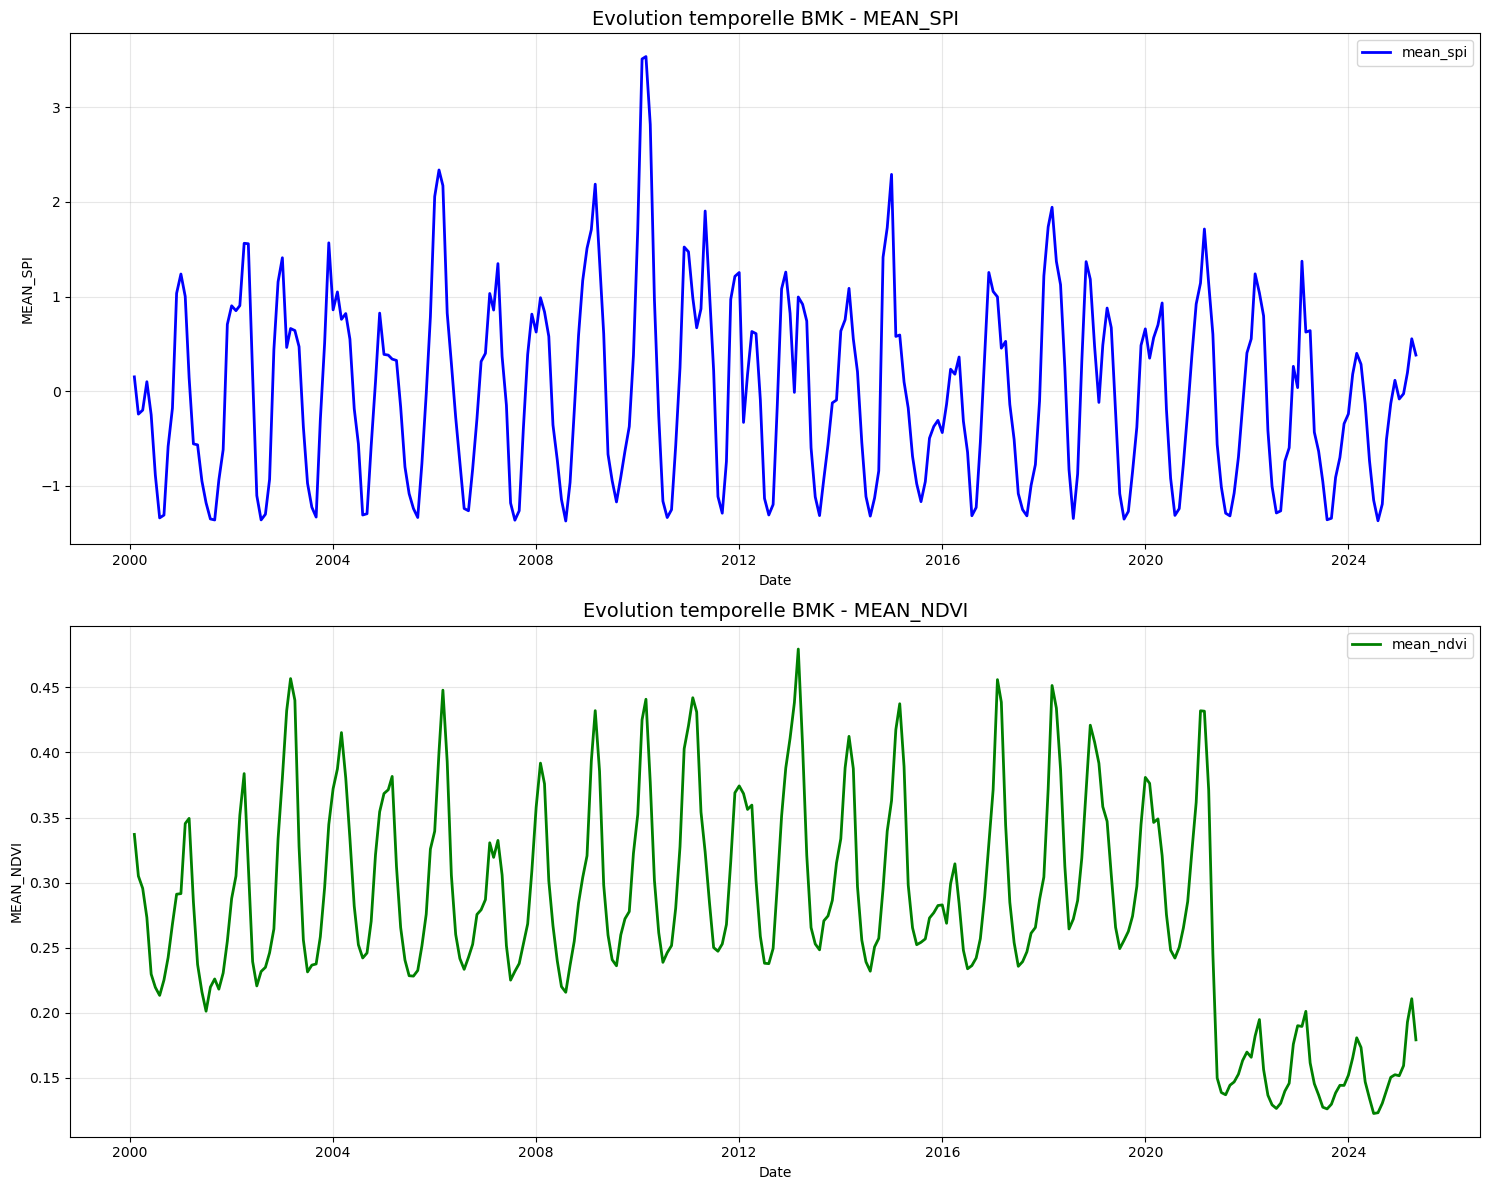

In [133]:
create_time_series_plot(merged_df, ['mean_spi', 'mean_ndvi'], 'Evolution temporelle BMK', save_path='time_series_plot.png')

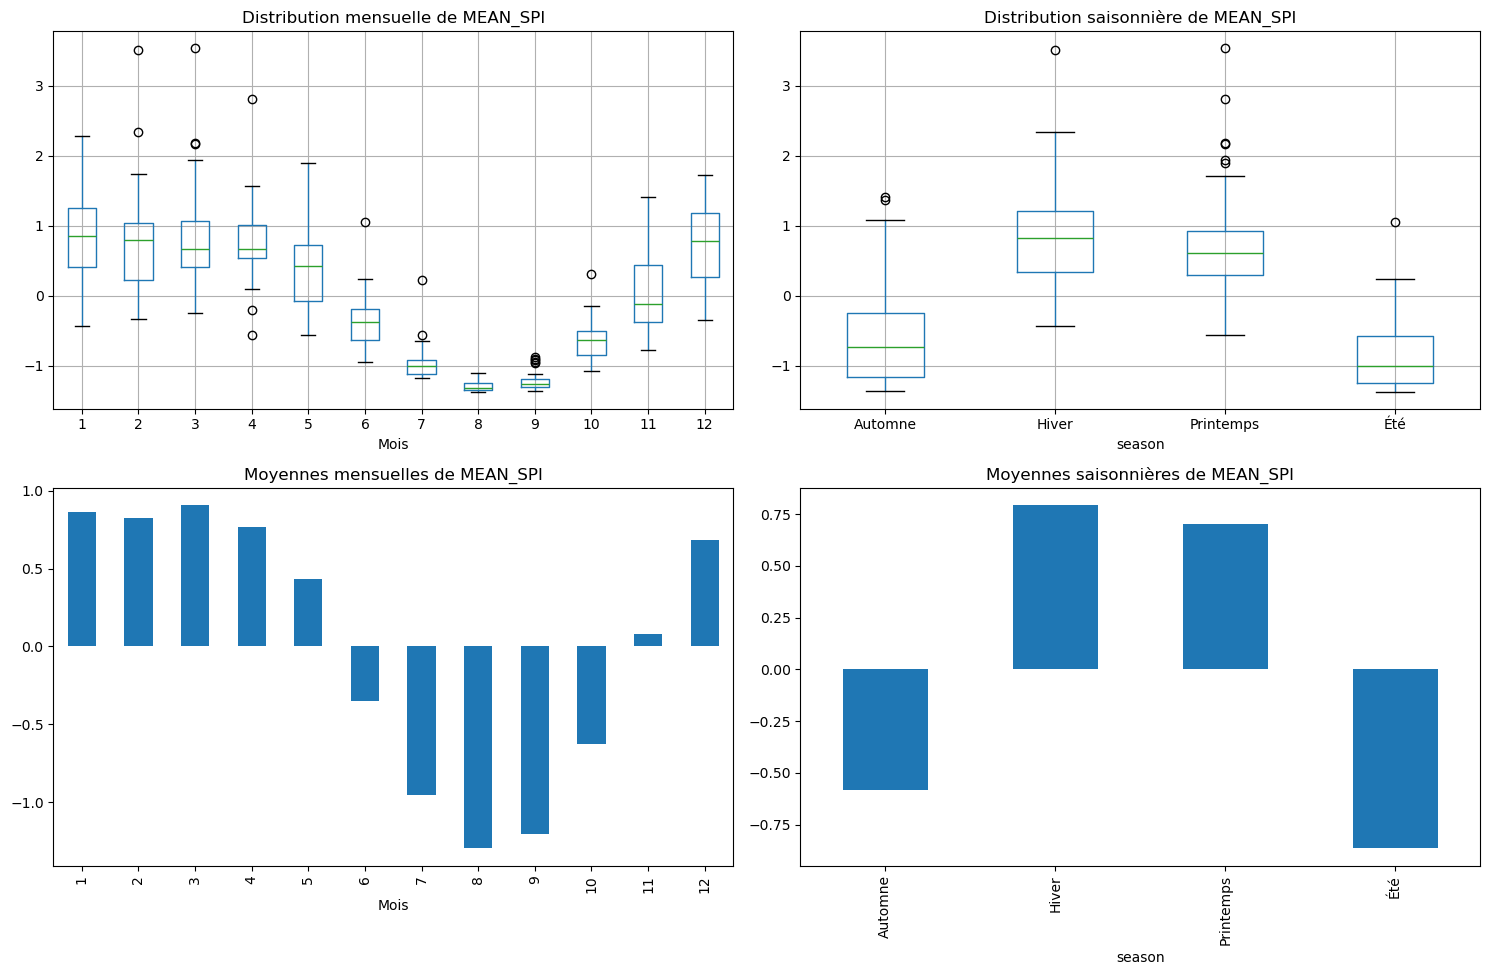

In [134]:
monthly_spi, seasonal_spi = analyze_seasonality(merged_df, 'mean_spi')


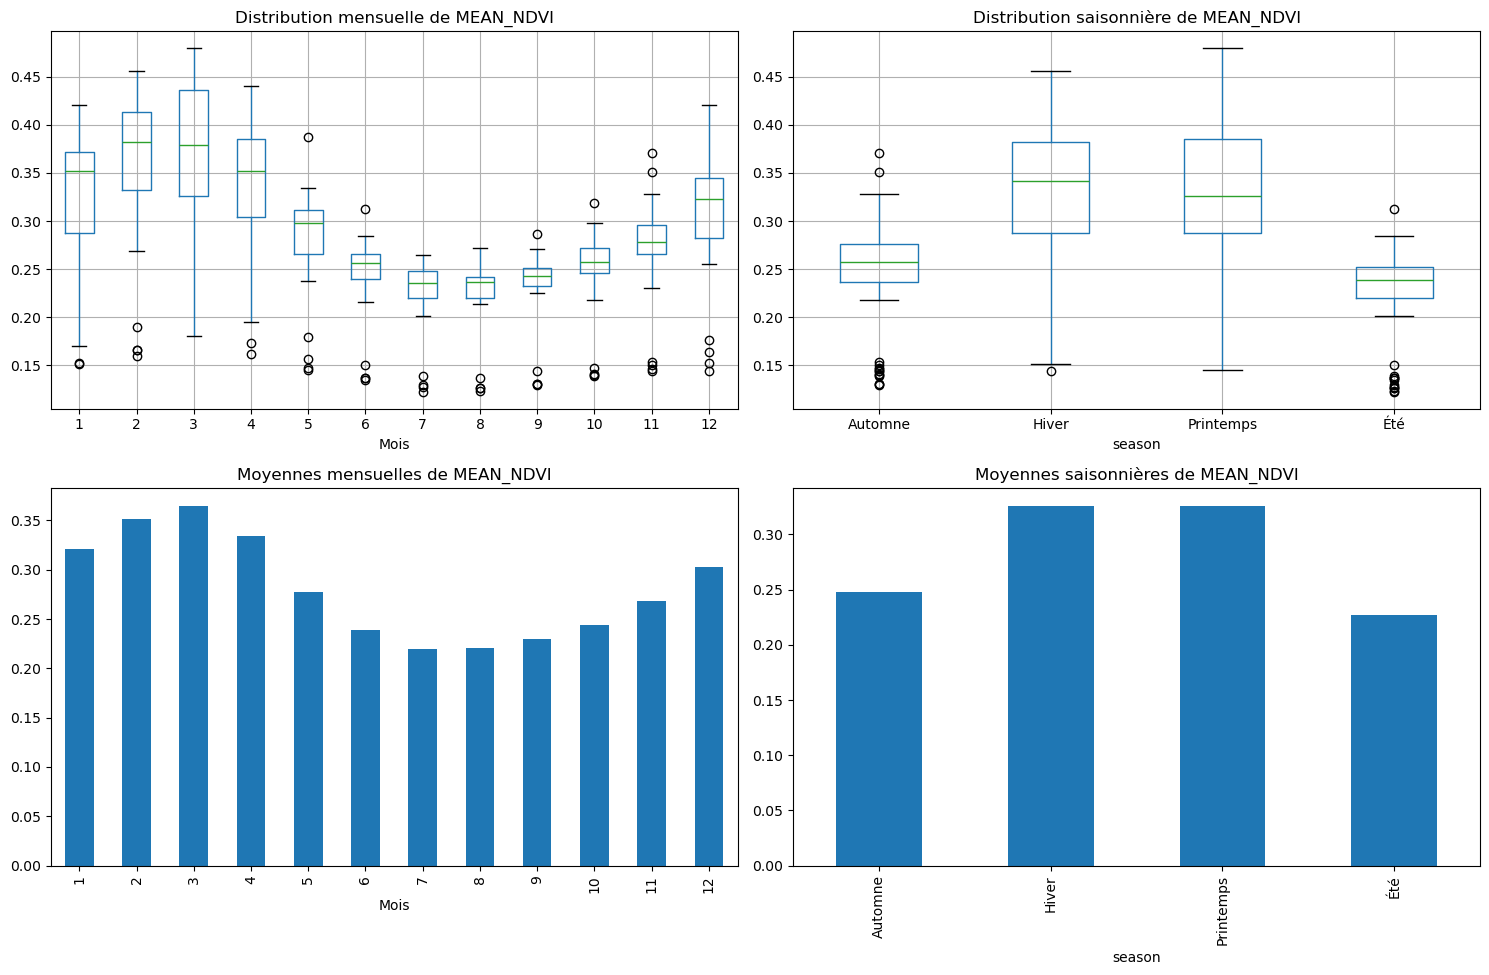

In [135]:
monthly_ndvi, seasonal_ndvi = analyze_seasonality(merged_df, 'mean_ndvi')


Analyse de la correlation entre SPI et NDVI:


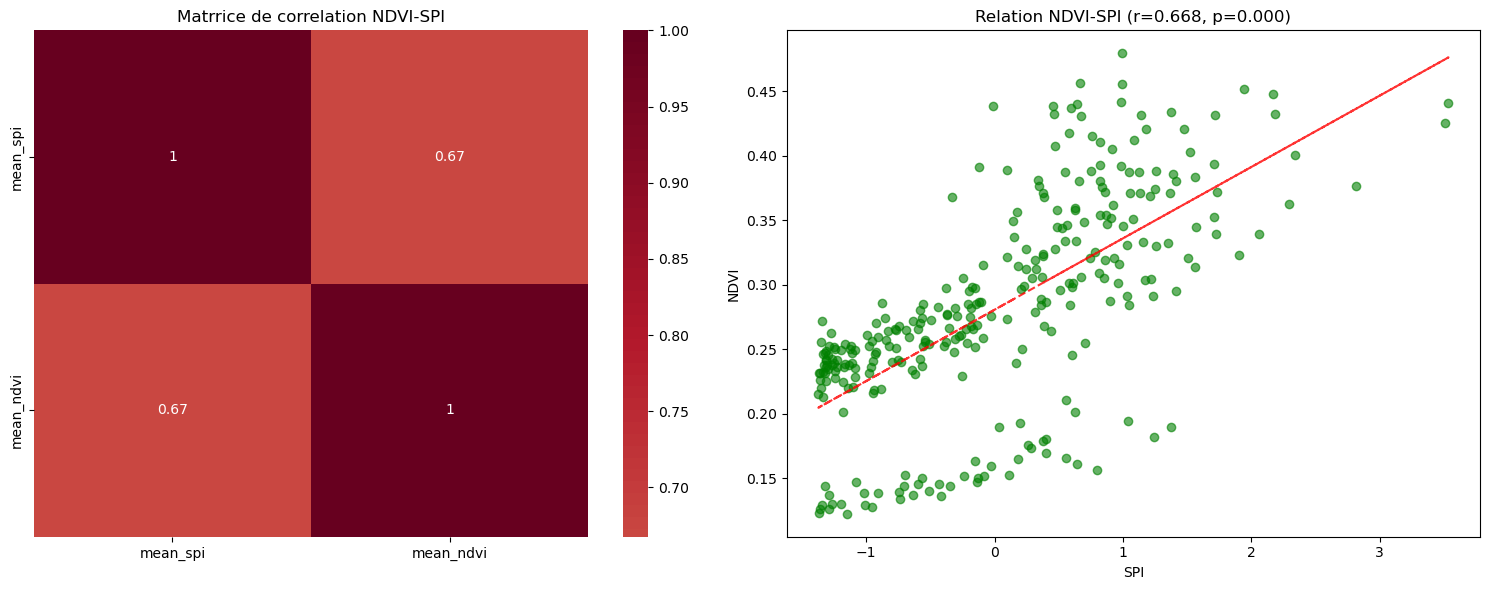

In [136]:
print('Analyse de la correlation entre SPI et NDVI:')
corr_coef, p_value = Correlation_analysis(merged_df)

**le SPI est un bon indicateur pour anticiper la reponse d ela vegentation (NDVI) et donc la sechresse, mais il n'explique pas tout à lui seul (temprerature , sols ..)**

## Detection et classification de la sechresse 

In [137]:
def classify_drought(spi_value , ndvi_value):
    drought_classes = []
    for spi , ndvi in zip(spi_value, ndvi_value):
        if pd.isna(spi) or pd.isna(ndvi):
            drought_classes.append('Inconnu')
        elif spi >= 1.5:
            drought_classes.append('Humide')
        elif -1 <spi <=1 :
            drought_classes.append('Normal')
        elif -1.5 < spi <= -1:
            drought_classes.append('Sechresse moderée ')
        elif -2 < spi <= -1.5:
            drought_classes.append('Sechresse sévère')
        elif spi <= -2: 
            drought_classes.append('Sechresse extrême')
    return drought_classes


In [138]:
def detect_drought_events(df, spi_threshold=-1.0, duration_threshold=3):
    df_copy= df.copy()
    df_copy['drought'] = df_copy['mean_spi'] < spi_threshold

    # identifier les periodes continues de sechresse 
    df_copy['drought_group'] = (df_copy['drought'] != df_copy['drought'].shift()).cumsum()

    drought_events = []

    for group_id, group in df_copy.groupby('drought_group'):
        if group['drought'].iloc[0] and len(group) >= duration_threshold:
            drought_events.append({
                'start_date': group['date'].min(),
                'end_date': group['date'].max(),
                'duration_months': len(group),
                'min_spi': group['mean_spi'].min(),
                'avg_spi': group['mean_spi'].mean(),
                'min_ndvi': group['mean_ndvi'].min(),
                'avg_ndvi': group['mean_ndvi'].mean()
            })
    return pd.DataFrame(drought_events)


In [146]:
drought_events =  detect_drought_events(merged_df)
print(drought_events)
print('\n')
print(f'Evenements de sechresse detectés :{len(drought_events)}')



   start_date   end_date  duration_months   min_spi   avg_spi  min_ndvi  \
0  2001-07-01 2001-09-01                3 -1.361173 -1.297216  0.201232   
1  2002-07-01 2002-09-01                3 -1.360748 -1.255109  0.220661   
2  2005-07-01 2005-09-01                3 -1.335073 -1.219619  0.228187   
3  2007-07-01 2007-09-01                3 -1.363397 -1.269894  0.225108   
4  2010-07-01 2010-09-01                3 -1.335720 -1.250165  0.238777   
5  2012-07-01 2012-09-01                3 -1.308340 -1.213380  0.237770   
6  2014-07-01 2014-09-01                3 -1.320354 -1.187483  0.231975   
7  2017-07-01 2017-09-01                3 -1.317790 -1.217765  0.235730   
8  2019-07-01 2019-09-01                3 -1.352203 -1.235802  0.249353   
9  2021-07-01 2021-10-01                4 -1.318096 -1.174757  0.137018   
10 2022-07-01 2022-09-01                3 -1.287201 -1.186617  0.126492   
11 2024-07-01 2024-09-01                3 -1.369624 -1.238638  0.122634   

    avg_ndvi  
0   0.215

In [148]:
if len(drought_events) > 0:
    drought_events.to_csv('drought_events_bmk.csv', index=False)
    print(drought_events.head())

  start_date   end_date  duration_months   min_spi   avg_spi  min_ndvi  \
0 2001-07-01 2001-09-01                3 -1.361173 -1.297216  0.201232   
1 2002-07-01 2002-09-01                3 -1.360748 -1.255109  0.220661   
2 2005-07-01 2005-09-01                3 -1.335073 -1.219619  0.228187   
3 2007-07-01 2007-09-01                3 -1.363397 -1.269894  0.225108   
4 2010-07-01 2010-09-01                3 -1.335720 -1.250165  0.238777   

   avg_ndvi  
0  0.215653  
1  0.229107  
2  0.229731  
3  0.231599  
4  0.245530  


In [147]:
if len(drought_events) >0 :
    fig = px.timeline(drought_events, 
                      x_start='start_date', 
                      x_end='end_date', 
                      y='duration_months', 
                      color='avg_spi',
                      title='Événements de sécheresse détectés (BMK)',
                      labels={'avg_spi': 'SPI moyen'})
    fig.update_layout(xaxis_title='Date', yaxis_title='Durée (mois)')
    fig.show()

## Modelisation predictive